# U-net for Pt grain detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Conv2DTranspose #,# MaxPooling2D, UpSampling2D, concatenate, , , Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from skimage import io
from skimage.util import img_as_float32

import cv2

import time

# from unet_model_with_functions_of_blocks import build_unet
# from keras.utils import normalize
# import os
# import cv2
# from PIL import Image
# import numpy as np
# from matplotlib import pyplot as plt
# from patchify import patchify, unpatchify
# import tifffile as tiff
# from sklearn.preprocessing import MinMaxScaler
# from keras.optimizers import Adam

In [2]:
# https://youtu.be/GAYJ81M58y8
"""
U-Net 
Segmentation of mitochondria using only 12 images and about 150 labeled objects
Dataset: https://www.epfl.ch/labs/cvlab/data/data-em/
"""

'\nU-Net \nSegmentation of mitochondria using only 12 images and about 150 labeled objects\nDataset: https://www.epfl.ch/labs/cvlab/data/data-em/\n'

## Defining the model

In [3]:
# Building Unet by dividing encoder and decoder into blocks
def conv_block(inp, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inp)
    # x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    # x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    # Conv block followed by maxpooling
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   


def decoder_block(inp, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inp)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [4]:
def jacard_coef(y_true, y_pred):
#     print(y_true)
#     print(y_pred)
    
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    return -jacard_coef(y_true_float, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

## Train/test data management

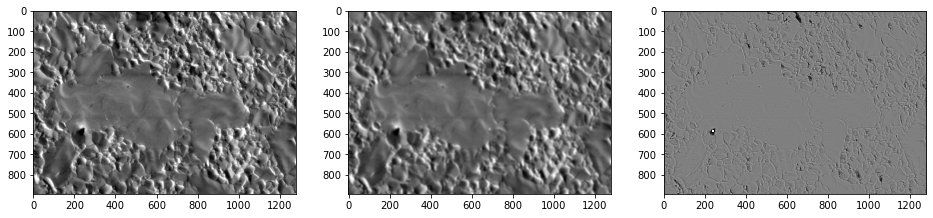

In [5]:
img_full = io.imread(r"train_test\full_image.tif", as_gray=True)
img_full = img_as_float32(img_full)
gaussian = cv2.GaussianBlur(img_full, (9,9), 50) # not exported
divide = cv2.divide(img_full, gaussian, scale=0.5) 
divide[divide > 1] = 1
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(img_full, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(gaussian, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(divide, cmap='gray')
plt.show()

In [6]:
# plt.hist(img_full.ravel(), bins="fd")
# plt.show()
# plt.hist(divide.ravel(), bins="fd")
# plt.show()

In [7]:
img1 = img_full[:512, :512] # train
img2 = img_full[:512, 512:1024] # test

mask1 = io.imread(r"train_test\full_image_mask.tif", as_gray=True)[:512, :512]
mask1 = (mask1 > 0).astype(int)
mask2 = io.imread(r"train_test\full_image_mask.tif", as_gray=True)[:512, 512:1024]
mask2 = (mask2 > 0).astype(int)

In [8]:
# plt.imshow(img1, cmap='gray')
# img1.shape, img2.shape

In [9]:
X_train = np.expand_dims([img1], -1)
y_train = np.expand_dims([mask1], -1)

X_test = np.expand_dims([img2], -1)
y_test = np.expand_dims([mask2], -1)

In [10]:
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [11]:
# plt.hist(y_train.ravel(), bins=32)
# plt.show()

In [12]:
# plt.subplot(1, 2, 1)
# plt.imshow(X_train[0, :, :, 0], cmap='gray')
# plt.subplot(1, 2, 2)
# plt.imshow(y_train[0, :, :, 0], cmap='gray')
# plt.show()

## Function for model evaluation

In [13]:
# def plot_history(history):
#     #plot the training and validation accuracy and loss at each epoch
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(1, len(loss) + 1)
#     plt.plot(epochs, loss, 'y', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
#     plt.title('Training and validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.ylim(0, 2)
#     plt.show()

#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']

#     plt.plot(epochs, acc, 'y', label='Training acc')
#     plt.plot(epochs, val_acc, 'r', label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()

In [14]:
def preview_predict(X, y_true=None, model=None):
    # creates a preview of the prediction
    if model is None:
        model = model
    X = np.expand_dims(X, axis=0)
    y_pred = model.predict(X)[0]
    y_pred_thresholded = y_pred > 0.5

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.imshow(X[0], cmap='gray')
    plt.title("Input image")    
    if y_true is not None:
        plt.subplot(2, 2, 2)
        plt.imshow(y_true, cmap='gray')
        plt.title("true borders")    
    plt.subplot(2, 2, 3)
    plt.imshow(y_pred, cmap='jet')
    plt.title("predicted")    
    plt.subplot(2, 2, 4)
    plt.imshow(y_pred_thresholded, cmap='gray')
    plt.title("predicted thresh 0.5")
    # plt.subplot(1, 3, 3)
    # plt.hist(y_pred.ravel(), bins="fd")
    plt.show()

# Very simple model

## build and train a model

In [15]:
tf.keras.backend.clear_session()

In [16]:
IMG_HEIGHT = 512
IMG_WIDTH  = 512
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate = 1e-3),
              loss='binary_crossentropy',
#               metrics=['accuracy']
              metrics = jacard_coef
             )
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
# very simple fit
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=300)

Epoch 1/300
1/1 [==============================] - 17s 17s/step - loss: 0.6840 - jacard_coef: 0.0679 - val_loss: 0.6313 - val_jacard_coef: 0.1046
Epoch 2/300
1/1 [==============================] - 1s 606ms/step - loss: 0.6262 - jacard_coef: 0.0674 - val_loss: 0.5071 - val_jacard_coef: 0.0974
Epoch 3/300
1/1 [==============================] - 1s 631ms/step - loss: 0.4841 - jacard_coef: 0.0644 - val_loss: 0.9806 - val_jacard_coef: 0.0027
Epoch 4/300
1/1 [==============================] - 1s 615ms/step - loss: 0.5674 - jacard_coef: 0.0032 - val_loss: 0.3995 - val_jacard_coef: 0.0802
Epoch 5/300
1/1 [==============================] - 1s 624ms/step - loss: 0.3363 - jacard_coef: 0.0566 - val_loss: 0.4179 - val_jacard_coef: 0.0887
Epoch 6/300
1/1 [==============================] - 1s 614ms/step - loss: 0.3689 - jacard_coef: 0.0608 - val_loss: 0.4040 - val_jacard_coef: 0.0870
Epoch 7/300
1/1 [==============================] - 1s 614ms/step - loss: 0.3485 - jacard_coef: 0.0601 - val_loss: 0.384

1/1 [==============================] - 1s 636ms/step - loss: 0.3113 - jacard_coef: 0.0720 - val_loss: 0.5163 - val_jacard_coef: 0.0740
Epoch 57/300
1/1 [==============================] - 1s 617ms/step - loss: 0.3271 - jacard_coef: 0.0598 - val_loss: 0.4363 - val_jacard_coef: 0.0991
Epoch 58/300
1/1 [==============================] - 1s 637ms/step - loss: 0.2771 - jacard_coef: 0.0832 - val_loss: 0.3152 - val_jacard_coef: 0.1586
Epoch 59/300
1/1 [==============================] - 1s 629ms/step - loss: 0.2033 - jacard_coef: 0.1377 - val_loss: 0.2343 - val_jacard_coef: 0.2169
Epoch 60/300
1/1 [==============================] - 1s 628ms/step - loss: 0.1646 - jacard_coef: 0.1769 - val_loss: 0.2573 - val_jacard_coef: 0.2055
Epoch 61/300
1/1 [==============================] - 1s 626ms/step - loss: 0.2151 - jacard_coef: 0.1488 - val_loss: 0.2835 - val_jacard_coef: 0.1925
Epoch 62/300
1/1 [==============================] - 1s 632ms/step - loss: 0.2486 - jacard_coef: 0.1352 - val_loss: 0.2481 - v

1/1 [==============================] - 1s 619ms/step - loss: 0.0969 - jacard_coef: 0.4522 - val_loss: 0.1168 - val_jacard_coef: 0.5458
Epoch 112/300
1/1 [==============================] - 1s 628ms/step - loss: 0.0939 - jacard_coef: 0.4623 - val_loss: 0.1211 - val_jacard_coef: 0.5412
Epoch 113/300
1/1 [==============================] - 1s 632ms/step - loss: 0.0960 - jacard_coef: 0.4703 - val_loss: 0.1168 - val_jacard_coef: 0.5488
Epoch 114/300
1/1 [==============================] - 1s 615ms/step - loss: 0.0930 - jacard_coef: 0.4769 - val_loss: 0.1166 - val_jacard_coef: 0.5465
Epoch 115/300
1/1 [==============================] - 1s 628ms/step - loss: 0.0940 - jacard_coef: 0.4619 - val_loss: 0.1102 - val_jacard_coef: 0.5596
Epoch 116/300
1/1 [==============================] - 1s 632ms/step - loss: 0.0884 - jacard_coef: 0.4828 - val_loss: 0.1148 - val_jacard_coef: 0.5531
Epoch 117/300
1/1 [==============================] - 1s 633ms/step - loss: 0.0911 - jacard_coef: 0.4826 - val_loss: 0.10

1/1 [==============================] - 1s 631ms/step - loss: 0.0824 - jacard_coef: 0.5326 - val_loss: 0.1018 - val_jacard_coef: 0.6145
Epoch 167/300
1/1 [==============================] - 1s 622ms/step - loss: 0.0800 - jacard_coef: 0.5548 - val_loss: 0.1004 - val_jacard_coef: 0.6162
Epoch 168/300
1/1 [==============================] - 1s 617ms/step - loss: 0.0789 - jacard_coef: 0.5566 - val_loss: 0.1033 - val_jacard_coef: 0.6053
Epoch 169/300
1/1 [==============================] - 1s 628ms/step - loss: 0.0794 - jacard_coef: 0.5413 - val_loss: 0.0976 - val_jacard_coef: 0.6154
Epoch 170/300
1/1 [==============================] - 1s 628ms/step - loss: 0.0756 - jacard_coef: 0.5548 - val_loss: 0.1005 - val_jacard_coef: 0.6102
Epoch 171/300
1/1 [==============================] - 1s 622ms/step - loss: 0.0781 - jacard_coef: 0.5521 - val_loss: 0.0972 - val_jacard_coef: 0.6143
Epoch 172/300
1/1 [==============================] - 1s 638ms/step - loss: 0.0748 - jacard_coef: 0.5553 - val_loss: 0.10

1/1 [==============================] - 1s 630ms/step - loss: 0.0638 - jacard_coef: 0.5948 - val_loss: 0.1027 - val_jacard_coef: 0.6280
Epoch 222/300
1/1 [==============================] - 1s 618ms/step - loss: 0.0630 - jacard_coef: 0.6003 - val_loss: 0.1034 - val_jacard_coef: 0.6306
Epoch 223/300
1/1 [==============================] - 1s 624ms/step - loss: 0.0617 - jacard_coef: 0.6074 - val_loss: 0.1046 - val_jacard_coef: 0.6281
Epoch 224/300
1/1 [==============================] - 1s 630ms/step - loss: 0.0608 - jacard_coef: 0.6092 - val_loss: 0.1045 - val_jacard_coef: 0.6298
Epoch 225/300
1/1 [==============================] - 1s 629ms/step - loss: 0.0590 - jacard_coef: 0.6146 - val_loss: 0.1075 - val_jacard_coef: 0.6277
Epoch 226/300
1/1 [==============================] - 1s 607ms/step - loss: 0.0581 - jacard_coef: 0.6169 - val_loss: 0.1079 - val_jacard_coef: 0.6267
Epoch 227/300
1/1 [==============================] - 1s 625ms/step - loss: 0.0568 - jacard_coef: 0.6217 - val_loss: 0.10

1/1 [==============================] - 1s 639ms/step - loss: 0.0260 - jacard_coef: 0.8149 - val_loss: 0.1451 - val_jacard_coef: 0.6719
Epoch 277/300
1/1 [==============================] - 1s 631ms/step - loss: 0.0233 - jacard_coef: 0.8124 - val_loss: 0.1427 - val_jacard_coef: 0.6722
Epoch 278/300
1/1 [==============================] - 1s 635ms/step - loss: 0.0215 - jacard_coef: 0.8204 - val_loss: 0.1503 - val_jacard_coef: 0.6688
Epoch 279/300
1/1 [==============================] - 1s 633ms/step - loss: 0.0212 - jacard_coef: 0.8296 - val_loss: 0.1589 - val_jacard_coef: 0.6636
Epoch 280/300
1/1 [==============================] - 1s 633ms/step - loss: 0.0201 - jacard_coef: 0.8313 - val_loss: 0.1526 - val_jacard_coef: 0.6686
Epoch 281/300
1/1 [==============================] - 1s 617ms/step - loss: 0.0186 - jacard_coef: 0.8391 - val_loss: 0.1519 - val_jacard_coef: 0.6702
Epoch 282/300
1/1 [==============================] - 1s 639ms/step - loss: 0.0186 - jacard_coef: 0.8416 - val_loss: 0.16

## review the model

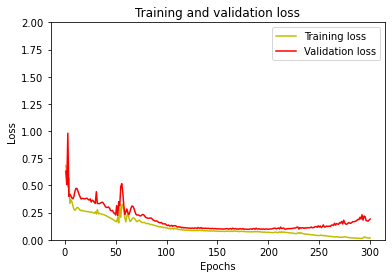

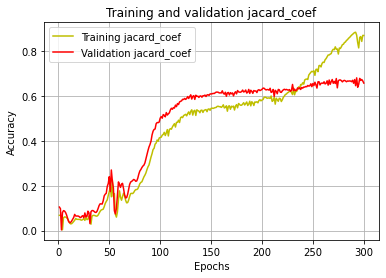

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 2)
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training jacard_coef')
plt.plot(epochs, val_acc, 'r', label='Validation jacard_coef')
plt.title('Training and validation jacard_coef')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

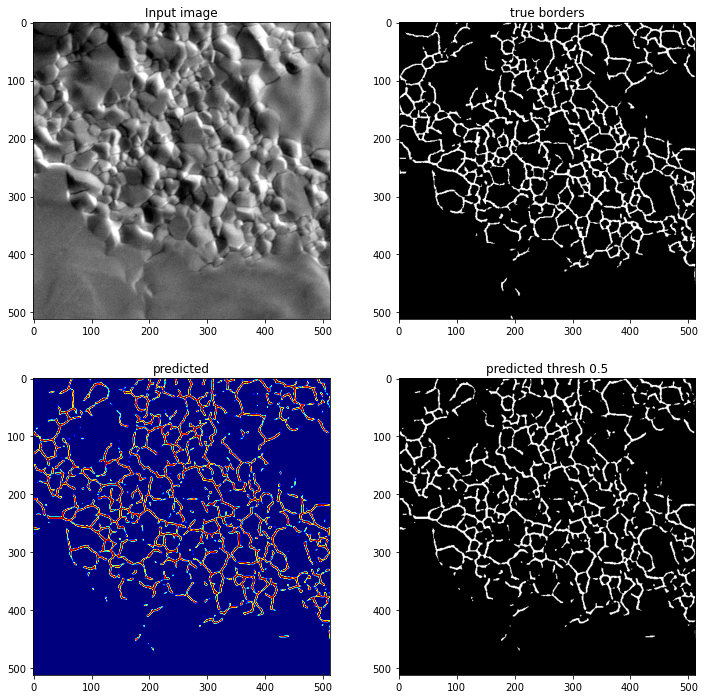

In [19]:
preview_predict(X_test[0], y_test[0], model=model)

# custom loss function - Jacard (equal to IoU)

In [15]:
tf.keras.backend.clear_session()

In [16]:
IMG_HEIGHT = 512
IMG_WIDTH  = 512
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# tf.random.set_seed(27) # 150 epoches give validation jacard= ~0.7; more epoches produce soikes up and down
# tf.random.set_seed(2) # validation jacard sticks to -0.1187  abd==nd cannot improve
tf.random.set_seed(9) # 100 epoches give validation jacard= ~0.7; more epoches only imporve the train score - overfitting


model2 = build_unet(input_shape)
model2.compile(optimizer=Adam(learning_rate = 1e-3),
                # loss='binary_crossentropy',
              loss=[jacard_coef_loss],
              metrics = jacard_coef
             )
model2.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
with tf.device("/gpu:0"):
    history2 = model2.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=300)

Epoch 1/300
1/1 [==============================] - 17s 17s/step - loss: -0.0681 - jacard_coef: 0.0681 - val_loss: -0.1073 - val_jacard_coef: 0.1073
Epoch 2/300
1/1 [==============================] - 1s 606ms/step - loss: -0.0686 - jacard_coef: 0.0686 - val_loss: -0.1088 - val_jacard_coef: 0.1088
Epoch 3/300
1/1 [==============================] - 1s 619ms/step - loss: -0.0694 - jacard_coef: 0.0694 - val_loss: -0.1115 - val_jacard_coef: 0.1115
Epoch 4/300
1/1 [==============================] - 1s 603ms/step - loss: -0.0707 - jacard_coef: 0.0707 - val_loss: -0.1163 - val_jacard_coef: 0.1163
Epoch 5/300
1/1 [==============================] - 1s 601ms/step - loss: -0.0730 - jacard_coef: 0.0730 - val_loss: -0.1217 - val_jacard_coef: 0.1217
Epoch 6/300
1/1 [==============================] - 1s 607ms/step - loss: -0.0753 - jacard_coef: 0.0753 - val_loss: -0.1251 - val_jacard_coef: 0.1251
Epoch 7/300
1/1 [==============================] - 1s 601ms/step - loss: -0.0770 - jacard_coef: 0.0770 - va

Epoch 56/300
1/1 [==============================] - 1s 623ms/step - loss: -0.4543 - jacard_coef: 0.4543 - val_loss: -0.4997 - val_jacard_coef: 0.4997
Epoch 57/300
1/1 [==============================] - 1s 598ms/step - loss: -0.4556 - jacard_coef: 0.4556 - val_loss: -0.4827 - val_jacard_coef: 0.4827
Epoch 58/300
1/1 [==============================] - 1s 619ms/step - loss: -0.4392 - jacard_coef: 0.4392 - val_loss: -0.5250 - val_jacard_coef: 0.5250
Epoch 59/300
1/1 [==============================] - 1s 619ms/step - loss: -0.4781 - jacard_coef: 0.4781 - val_loss: -0.5124 - val_jacard_coef: 0.5124
Epoch 60/300
1/1 [==============================] - 1s 605ms/step - loss: -0.4607 - jacard_coef: 0.4607 - val_loss: -0.5155 - val_jacard_coef: 0.5155
Epoch 61/300
1/1 [==============================] - 1s 622ms/step - loss: -0.4717 - jacard_coef: 0.4717 - val_loss: -0.5117 - val_jacard_coef: 0.5117
Epoch 62/300
1/1 [==============================] - 1s 602ms/step - loss: -0.4697 - jacard_coef: 0.4

1/1 [==============================] - 1s 627ms/step - loss: -0.6924 - jacard_coef: 0.6924 - val_loss: -0.7104 - val_jacard_coef: 0.7104
Epoch 111/300
1/1 [==============================] - 1s 609ms/step - loss: -0.6989 - jacard_coef: 0.6989 - val_loss: -0.7092 - val_jacard_coef: 0.7092
Epoch 112/300
1/1 [==============================] - 1s 613ms/step - loss: -0.6966 - jacard_coef: 0.6966 - val_loss: -0.7104 - val_jacard_coef: 0.7104
Epoch 113/300
1/1 [==============================] - 1s 602ms/step - loss: -0.7012 - jacard_coef: 0.7012 - val_loss: -0.7113 - val_jacard_coef: 0.7113
Epoch 114/300
1/1 [==============================] - 1s 607ms/step - loss: -0.7070 - jacard_coef: 0.7070 - val_loss: -0.7082 - val_jacard_coef: 0.7082
Epoch 115/300
1/1 [==============================] - 1s 623ms/step - loss: -0.7030 - jacard_coef: 0.7030 - val_loss: -0.7101 - val_jacard_coef: 0.7101
Epoch 116/300
1/1 [==============================] - 1s 602ms/step - loss: -0.7081 - jacard_coef: 0.7081 - v

1/1 [==============================] - 1s 622ms/step - loss: -0.7369 - jacard_coef: 0.7369 - val_loss: -0.7063 - val_jacard_coef: 0.7063
Epoch 165/300
1/1 [==============================] - 1s 601ms/step - loss: -0.7917 - jacard_coef: 0.7917 - val_loss: -0.7058 - val_jacard_coef: 0.7058
Epoch 166/300
1/1 [==============================] - 1s 618ms/step - loss: -0.7708 - jacard_coef: 0.7708 - val_loss: -0.7008 - val_jacard_coef: 0.7008
Epoch 167/300
1/1 [==============================] - 1s 609ms/step - loss: -0.7970 - jacard_coef: 0.7970 - val_loss: -0.6801 - val_jacard_coef: 0.6801
Epoch 168/300
1/1 [==============================] - 1s 618ms/step - loss: -0.7843 - jacard_coef: 0.7843 - val_loss: -0.6965 - val_jacard_coef: 0.6965
Epoch 169/300
1/1 [==============================] - 1s 605ms/step - loss: -0.7917 - jacard_coef: 0.7917 - val_loss: -0.7056 - val_jacard_coef: 0.7056
Epoch 170/300
1/1 [==============================] - 1s 620ms/step - loss: -0.8000 - jacard_coef: 0.8000 - v

1/1 [==============================] - 1s 619ms/step - loss: -0.9025 - jacard_coef: 0.9025 - val_loss: -0.6974 - val_jacard_coef: 0.6974
Epoch 219/300
1/1 [==============================] - 1s 607ms/step - loss: -0.9036 - jacard_coef: 0.9036 - val_loss: -0.6999 - val_jacard_coef: 0.6999
Epoch 220/300
1/1 [==============================] - 1s 613ms/step - loss: -0.9003 - jacard_coef: 0.9003 - val_loss: -0.6962 - val_jacard_coef: 0.6962
Epoch 221/300
1/1 [==============================] - 1s 614ms/step - loss: -0.9046 - jacard_coef: 0.9046 - val_loss: -0.7043 - val_jacard_coef: 0.7043
Epoch 222/300
1/1 [==============================] - 1s 616ms/step - loss: -0.8980 - jacard_coef: 0.8980 - val_loss: -0.6953 - val_jacard_coef: 0.6953
Epoch 223/300
1/1 [==============================] - 1s 622ms/step - loss: -0.9011 - jacard_coef: 0.9011 - val_loss: -0.7015 - val_jacard_coef: 0.7015
Epoch 224/300
1/1 [==============================] - 1s 617ms/step - loss: -0.9060 - jacard_coef: 0.9060 - v

1/1 [==============================] - 1s 607ms/step - loss: -0.9400 - jacard_coef: 0.9400 - val_loss: -0.7023 - val_jacard_coef: 0.7023
Epoch 273/300
1/1 [==============================] - 1s 628ms/step - loss: -0.9402 - jacard_coef: 0.9402 - val_loss: -0.7023 - val_jacard_coef: 0.7023
Epoch 274/300
1/1 [==============================] - 1s 613ms/step - loss: -0.9404 - jacard_coef: 0.9404 - val_loss: -0.7018 - val_jacard_coef: 0.7018
Epoch 275/300
1/1 [==============================] - 1s 615ms/step - loss: -0.9404 - jacard_coef: 0.9404 - val_loss: -0.7013 - val_jacard_coef: 0.7013
Epoch 276/300
1/1 [==============================] - 1s 611ms/step - loss: -0.9405 - jacard_coef: 0.9405 - val_loss: -0.7011 - val_jacard_coef: 0.7011
Epoch 277/300
1/1 [==============================] - 1s 597ms/step - loss: -0.9407 - jacard_coef: 0.9407 - val_loss: -0.7010 - val_jacard_coef: 0.7010
Epoch 278/300
1/1 [==============================] - 1s 613ms/step - loss: -0.9408 - jacard_coef: 0.9408 - v

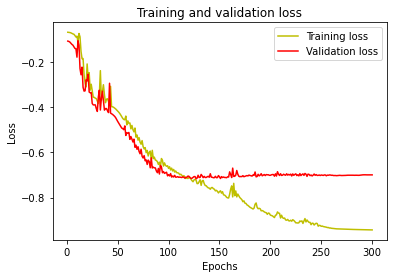

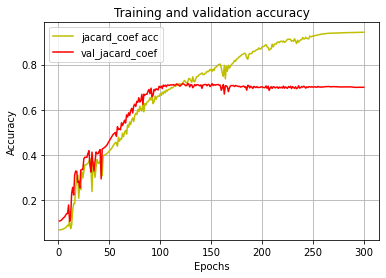

In [18]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history2.history['jacard_coef']
val_acc = history2.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='jacard_coef acc')
plt.plot(epochs, val_acc, 'r', label='val_jacard_coef')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

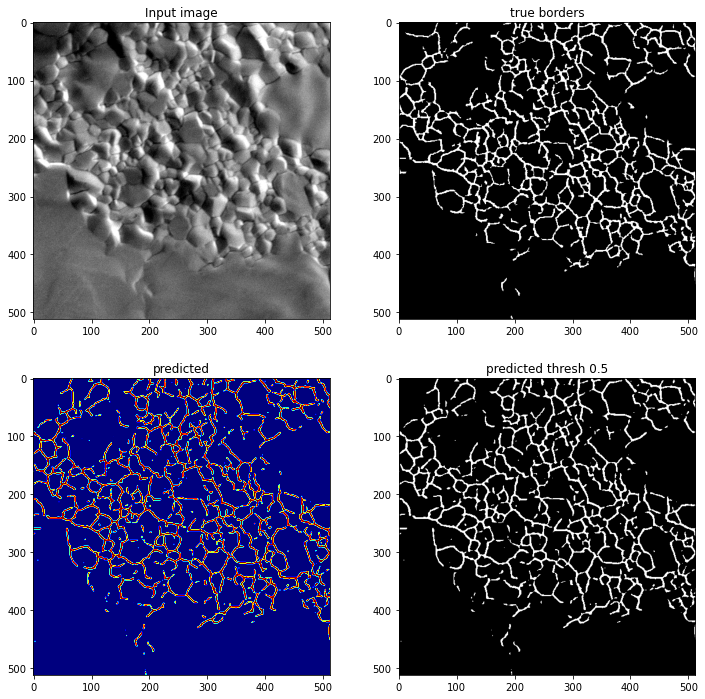

In [19]:
preview_predict(X_test[0], y_test[0], model=model2)

C:\Users\a1048794\AppData\Local\Temp/ipykernel_23592/4271030610.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.hist(np.array(model2.layers[1].weights).ravel(), bins="fd")


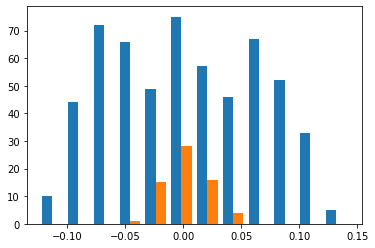

In [45]:
plt.hist(np.array(model2.layers[1].weights).ravel(), bins="fd")
plt.show()

In [46]:
model2.layers[1].weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 64) dtype=float32, numpy=
 array([[[[-1.45839350e-02,  5.33959381e-02,  2.59115305e-02,
           -2.62119696e-02,  1.50986258e-02, -5.39343171e-02,
            5.91737740e-02, -1.86638907e-02,  9.56384018e-02,
            2.42388509e-02,  8.84994864e-02, -5.54048344e-02,
           -2.60141045e-02, -7.97196403e-02,  6.18027598e-02,
            2.75204610e-02, -5.88226914e-02, -8.98481831e-02,
            1.03039533e-01,  6.00248724e-02,  6.00098632e-02,
           -2.27616746e-02,  1.02258593e-01, -5.49649373e-02,
           -1.79363843e-02, -7.50519277e-04,  9.25048068e-02,
           -3.77785750e-02,  2.89640427e-02, -3.22390832e-02,
            1.04724668e-01,  4.83951829e-02,  4.43615019e-02,
           -6.66554272e-02,  9.32658389e-02,  7.89829940e-02,
           -1.17897559e-02,  6.93487450e-02, -5.94172962e-02,
            1.12745240e-01, -4.36543114e-02,  2.04712600e-02,
            6.19475096e-02,  5.08538410e-02,  6.89632520e-

## complex model with augmentation

stop = sknfskfns

In [25]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
img_data_gen_args = dict(rotation_range=360,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=360,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

#image_data_generator.fit(X_train, augment=True, seed=seed)

In [26]:
batch_size= 8
seed = 24

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

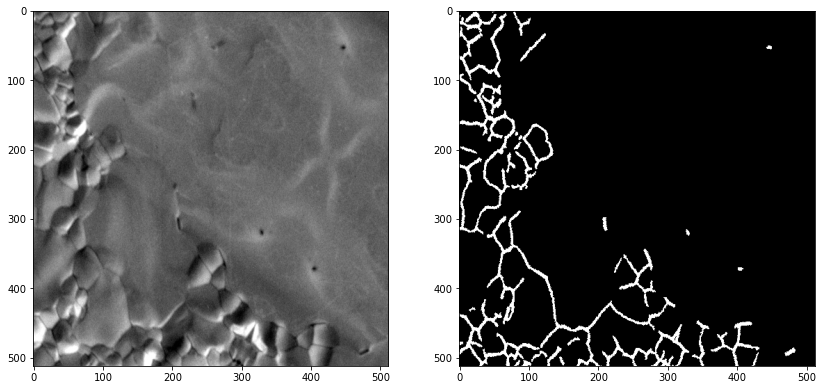

In [27]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0, 1):
    image = x[i]
    mask = y[i]
    plt.figure(figsize=(14,8))
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

In [28]:
# steps_per_epoch = 3*(len(X_train))//batch_size
start = time.time()
history = model.fit(my_generator,
                    validation_data=validation_datagen, 
                    steps_per_epoch=5, 
                    validation_steps=5,
                    epochs=25)
print(f"elapsed time: {time.time() - start}s")

Epoch 1/25
5/5 [==============================] - 4s 733ms/step - loss: 0.6383 - jacard_coef: 0.1453 - val_loss: 5.9197 - val_jacard_coef: 0.1697
Epoch 2/25
5/5 [==============================] - 3s 703ms/step - loss: 1.6442 - jacard_coef: 0.0593 - val_loss: 0.4599 - val_jacard_coef: 0.0846
Epoch 3/25
5/5 [==============================] - 3s 700ms/step - loss: 0.3664 - jacard_coef: 0.0823 - val_loss: 0.4448 - val_jacard_coef: 0.1060
Epoch 4/25
5/5 [==============================] - 3s 700ms/step - loss: 0.3119 - jacard_coef: 0.0645 - val_loss: 0.5400 - val_jacard_coef: 0.0519
Epoch 5/25
5/5 [==============================] - 3s 700ms/step - loss: 0.3936 - jacard_coef: 0.0603 - val_loss: 0.4476 - val_jacard_coef: 0.0913
Epoch 6/25
5/5 [==============================] - 3s 699ms/step - loss: 0.3579 - jacard_coef: 0.0714 - val_loss: 0.5630 - val_jacard_coef: 0.0634
Epoch 7/25
5/5 [==============================] - 3s 701ms/step - loss: 0.3407 - jacard_coef: 0.0492 - val_loss: 0.4771 - va

## Model analysis

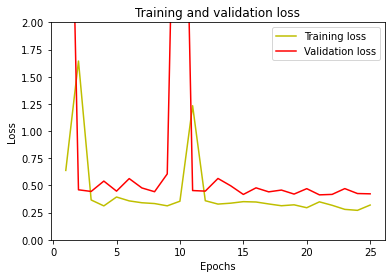

KeyError: 'accuracy'

In [29]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 2)
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred_thresholded = y_pred > 0.5
plt.imshow(y_pred[0], cmap='jet')
plt.show()
# plt.figure(figsize=(12,12))
plt.imshow(y_pred_thresholded[0], cmap='gray')
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

## BACK UP original implementation

In [ ]:
stop = fasdsa

In [ ]:
# https://youtu.be/GAYJ81M58y8
"""
U-Net 
Segmentation of mitochondria using only 12 images and about 150 labeled objects
Dataset: https://www.epfl.ch/labs/cvlab/data/data-em/
"""

from unet_model_with_functions_of_blocks import build_unet
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam

#12 images only
large_image_stack = tiff.imread('small_dataset_for_training/images/12_training_mito_images.tif')
large_mask_stack = tiff.imread('small_dataset_for_training/masks/12_training_mito_masks.tif')

all_img_patches = []
for img in range(large_image_stack.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_image = large_image_stack[img]
    
    patches_img = patchify(large_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            #scaler = MinMaxScaler()
            #single_patch_img= scaler.fit_transform(single_patch_img)
            
            all_img_patches.append(single_patch_img)

#This will split the image into small images of shape [3,3]
images = np.array(all_img_patches)
images = np.expand_dims(images, -1)

all_mask_patches = []
for img in range(large_mask_stack.shape[0]):
    #print(img)     #just stop here to see all file names printed
     
    large_mask = large_mask_stack[img]
    
    patches_mask = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = single_patch_mask / 255.
            
            all_mask_patches.append(single_patch_mask)

#This will split the image into small images of shape [3,3]
masks = np.array(all_mask_patches)
masks = np.expand_dims(masks, -1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.25, random_state = 0)


#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()



IMG_HEIGHT = images.shape[1]
IMG_WIDTH  = images.shape[2]
IMG_CHANNELS = images.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)
model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
#image_data_generator.fit(X_train, augment=True, seed=seed)

batch_size= 8

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
#mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


steps_per_epoch = 3*(len(X_train))//batch_size


history = model.fit_generator(my_generator, validation_data=validation_datagen, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_steps=steps_per_epoch, epochs=25)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

#Predict on a few images
#model = get_model()
#model.load_weights('mitochondria_50_plus_100_epochs.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()